In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [42]:
# Load libraries
import pandas as pd
from google.colab import files
from sklearn import preprocessing
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
# Load training data
train_data = pd.read_csv('gdrive/MyDrive/train_windy.csv')
len(train_data)

28200

In [15]:
train_data.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,NaN,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521
1,WM_698,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,NaN,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275
2,WM_39146,2019-09-14 14:03:20,95.484724,NaN,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342
3,WM_6757,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,ABC,NaN,4.857385,0.367140,24.287767,14.851089
4,WM_21521,2019-05-04 03:13:20,10.722890,NaN,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,NaN,0.453374,27.971650,3.519074


In [17]:
# Load testing data
test_data = pd.read_csv('gdrive/MyDrive/test_windy.csv')
len(test_data)

12086

In [18]:
test_data.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431
1,WM_18723,2019-03-30 07:43:20,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,NaN,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823
2,WM_34552,2019-08-10 11:33:20,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677
3,WM_28570,2019-06-26 03:53:20,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,NaN,23.886434,13.501595,NaN,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426
4,WM_36934,2019-08-27 16:43:20,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440


In [19]:
# Get the number of missing data points per column
missing_values_count_train = train_data.isnull().sum()
print(missing_values_count_train)

tracking_id                          0
datetime                             0
wind_speed(m/s)                    273
atmospheric_temperature(°C)       3450
shaft_temperature(°C)                2
blades_angle(°)                    216
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2707
area_temperature(°C)                 0
windmill_body_temperature(°C)     2363
wind_direction(°)                 5103
resistance(ohm)                      1
rotor_torque(N-m)                  572
turbine_status                    1759
cloud_level                        276
blade_length(m)                   5093
blade_breadth(m)                     0
windmill_height(m)                 543
windmill_generated_power(kW/h)     207
dtype: int64


In [20]:
# Get the number of missing data points per column
missing_values_count_test = test_data.isnull().sum()
print(missing_values_count_test)

tracking_id                         0
datetime                            0
wind_speed(m/s)                   126
atmospheric_temperature(°C)      1427
shaft_temperature(°C)               1
blades_angle(°)                   106
gearbox_temperature(°C)             1
engine_temperature(°C)              5
motor_torque(N-m)                  11
generator_temperature(°C)           5
atmospheric_pressure(Pascal)     1151
area_temperature(°C)                1
windmill_body_temperature(°C)     926
wind_direction(°)                2160
resistance(ohm)                     0
rotor_torque(N-m)                 281
turbine_status                    797
cloud_level                       125
blade_length(m)                  2114
blade_breadth(m)                    0
windmill_height(m)                255
dtype: int64


In [21]:
# Imputing all rows with missing data
#train_modified = train_data.dropna()
train_imputed = train_data.fillna(method='bfill', axis=0).fillna(0)
train_imputed.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,45.033197,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521
1,WM_698,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,45.033197,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275
2,WM_39146,2019-09-14 14:03:20,95.484724,-99.000000,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342
3,WM_6757,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,ABC,Medium,4.857385,0.367140,24.287767,14.851089
4,WM_21521,2019-05-04 03:13:20,10.722890,30.326226,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,2.504098,0.453374,27.971650,3.519074


In [22]:
# Imputing all rows with missing data
test_imputed = test_data.fillna(method='bfill', axis=0).fillna(0)
test_imputed.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431
1,WM_18723,2019-03-30 07:43:20,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,214812.836175,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823
2,WM_34552,2019-08-10 11:33:20,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677
3,WM_28570,2019-06-26 03:53:20,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,16833.546517,23.886434,13.501595,442.425744,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426
4,WM_36934,2019-08-27 16:43:20,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440


In [23]:
# Plot statistics of Wind speed
print(train_imputed['wind_speed(m/s)'].describe())

count    28200.000000
mean        69.014553
std         76.231504
min       -496.211029
25%         20.902307
50%         93.300739
75%         95.268399
max        601.455670
Name: wind_speed(m/s), dtype: float64


In [24]:
features_num = ['wind_speed(m/s)', 'atmospheric_temperature(°C)', 'shaft_temperature(°C)', 'blades_angle(°)',
                'gearbox_temperature(°C)', 'engine_temperature(°C)', 'motor_torque(N-m)', 'generator_temperature(°C)',
                'atmospheric_pressure(Pascal)', 'area_temperature(°C)', 'windmill_body_temperature(°C)', 'wind_direction(°)',
                'resistance(ohm)', 'rotor_torque(N-m)', 'blade_length(m)', 'blade_breadth(m)', 'windmill_height(m)']
features_cat = ['cloud_level']
features_lab = ['turbine_status']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
    #(LabelEncoder(), features_lab),
)

y = train_imputed.pop('windmill_generated_power(kW/h)')
#train_imputed = train_imputed.iloc[:,[1,2,3,10,12]]
X = preprocessor.fit_transform(train_imputed)

#test_imputed = test_imputed.iloc[:,[1,2,3,10,12]]
test_X = preprocessor.fit_transform(test_imputed)

train_imputed.columns

Index(['tracking_id', 'datetime', 'wind_speed(m/s)',
       'atmospheric_temperature(°C)', 'shaft_temperature(°C)',
       'blades_angle(°)', 'gearbox_temperature(°C)', 'engine_temperature(°C)',
       'motor_torque(N-m)', 'generator_temperature(°C)',
       'atmospheric_pressure(Pascal)', 'area_temperature(°C)',
       'windmill_body_temperature(°C)', 'wind_direction(°)', 'resistance(ohm)',
       'rotor_torque(N-m)', 'turbine_status', 'cloud_level', 'blade_length(m)',
       'blade_breadth(m)', 'windmill_height(m)'],
      dtype='object')

In [25]:
#Train-test split
train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=1,test_size=0.2)

In [26]:
print(train_X[0])

[ 0.37982819 -2.24868305  0.20265802  0.20167612  0.12553187  0.22905639
  1.14264877  0.89414891 -1.46719915  1.44755477  0.49423948  1.55614776
  0.63356324  0.60025019  0.12047891 -0.2974015  -0.10351123  0.
  1.          0.        ]


In [28]:
model = keras.Sequential([
    # the hidden ReLU layers
    layers.Dense(units=128, activation='relu', input_shape=[20]),
    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=64, activation='relu'),
    # the linear output layer 
    layers.Dense(units=1),
])

In [30]:
model.compile(
    optimizer='adam',
    loss='mae',
)

In [32]:
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=256,
    epochs=100,
    verbose = 0
)

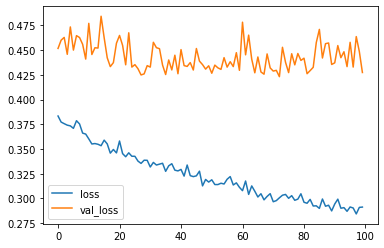

In [33]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

In [34]:
test_preds = model.predict(test_X)

In [43]:
# The lines below shows how to save predictions in format used for competition scoring.
output = pd.DataFrame({'tracking_id': test_data.tracking_id,
                       'datetime': test_data.datetime,
                       'windmill_generated_power(kW/h)': test_preds.flatten()})

output.head()
output.to_csv('submission_windy_dl.csv', index=False)
files.download('submission_windy_dl.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>